In [1]:
import pandas as pd
import numpy as np

In [2]:
def initialize_parameters(linear_dims):
    parameters = {} #initializeing the parameters dictionarry with null
    for i in range(0,len(linear_dims)-1):
        dim_name = "W" + str(i+1) # creating the dimension name
        bias_name = "b" + str(i+1) # creating the bias name

        # creating a random matrix of size n*m where n is linear_dims[i+1] and m is linear_dims[i]
        parameters[dim_name] = np.random.randn(linear_dims[i+1],linear_dims[i])
        
        #since bias starts after the input layer
        parameters[bias_name] = np.zeros(linear_dims[i+1]) 
    return parameters
    

Linear Forward


In [3]:
def linear_forward(A,W,b):
    # multiplying the weights and adding the bias matrix
    Z = np.matmul(W,np.transpose(A))+b

    # storing weights, input matrix and biases in a tuple
    cache = (W,A,b)
    
    return Z , cache

Activation Forward


In [4]:
# Had a problem with the import of the file so I decided to write the functions instead

In [5]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

In [6]:
def relu(Z):    
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache

In [7]:
def activation_forward(A,W,b,activation):

    # getting Z and the linear cache
    Z , linear_cache = linear_forward(A,W,b)

    # checking activation type
    if activation == "sigmoid":
        A , activation_cache = sigmoid(Z)
    elif activation == "relu":
        A , activation_cache = relu(Z)

    # retrurning the cache and Z after applying the activation funciton
    cache = (linear_cache , activation_cache)
    return A , cache


Model Forward

In [8]:
def model_forward(X,parameters):

    NN_len = int(len(parameters)/2) # getting length of the nueral network
    caches = []

    #first layer activation is done outside the loop because we are using X intead of AL
    AL , cache = activation_forward(X,parameters["W1"],parameters["b1"],activation="sigmoid")

    caches.append(cache)    # gets the cache for the layer then stores it in the caches list

    # itirates on all the layers carrying the new parameters to each layer AL 
    for i in range(1,NN_len):
        weight_name = "W" + str(i+1)
        bias_name = "b" + str(i+1)
        AL , cache = activation_forward(AL,parameters[weight_name],parameters[bias_name],activation="sigmoid")
        caches.append(cache)
    
    # returns the output of the last layer and all the data for the forward path in caches
    return AL , caches

In [9]:
def compute_cost(AL,Y):
    m = float(len(AL)) # getting length of the input

    # calculating the cost of the outputs (logistic cost function)
    J = (-1/m)*  ( (Y*np.log(np.transpose(AL)))+(1-Y)*np.log(1-np.transpose(AL)) )
    return J

BackProb


In [10]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

In [11]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

Linear Backward

In [12]:
def linear_backward(dZ,cache):
    W , A , b = cache #Extracting the parameters and output matrix of each layer

    m = 1   # number of samples 

    dA = np.matmul(dZ,W)    # caculating dA
    dW = (1/m) * dA*np.transpose([dZ]) # caculating dW
    db = (1/m) * np.sum(dZ,axis=-1)  # caculating db
    

    return dA , dW , db


Activation Backwards


In [13]:
def activation_backward(dA,cache,activation):
    
    linear_cache , activation_cache = cache #getting linear cache and activation cache
    
    if activation == "sigmoid":
        # if the layer is sigmoid then we must use the sigmoid backward function 
        dZ = sigmoid_backward(dA,activation_cache) 
    elif activation == "relu":
        # if the layer is relu then we must use the relu backward function 
        dZ = relu_backward(dA,activation_cache)
    
    dA , dW , db = linear_backward(dZ,linear_cache) #uses the calculated dZ to get dA,dW,db

    return dA , dW , db

Model Backwards


In [14]:
def model_backward(AL, Y, caches):
    grads = {}  #empty dictionary to store the output gradients
    L = len(caches) 
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))   #derivative of the output layer
    current_cache = caches[L-1]                             #getting our current position in the nnetwork

    # updating the dictionary with the first input which is the last layer in the neural network
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = activation_backward(dAL, current_cache, "sigmoid")

    # then moving backwards in the network we get the gradients of Z until we reach the input layer
    for l in reversed(range(L-1)):
        current_cache = caches[l]   #moving backwards 
        #getting the gradients
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "sigmoid")

        #adding the gradients to the gradients dictionary 
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    

    #returning the gradients dictionary
    return grads

Parameters Update

In [15]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # getting number of rows 

    #using gradient descend to update all the parameters in a vectorised form 
    for l in range(L):
        
        #updating theta 1
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)] 
        #updating theta 0
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

Importing the data

In [16]:
df = pd.read_csv(r"\Train_data.csv")
X = df.iloc[:,1:]
Y = df.iloc[:,0]

Constructing the Nural netwrok

In [17]:
row_X = np.array(X.iloc[0,:]) # getting the first row in X
row_Y = np.array(Y.iloc[0]) # getting the first item in Y
linear_dim = [13,5,5,1]     # shape of the neural network it has to have an input layer of 13 and an output of 1
                                
parameters = initialize_parameters(linear_dim)  # initializing the parameters using the shape of the network 

cost_history= []   #empty list ot record the cost
nepochs = 60        #number of times to go through the data
learning_rate = 1e-3    #learning step size

for epoch in range(nepochs):
    cost_sum = 0 #cost sum of all the tries through the epoch

    for i in range (0,len(Y)):      # the main loop of the netwrork 
        AL ,caches= model_forward(row_X,parameters)     # takes the first row and starts the model
        cost = compute_cost(AL,row_Y)                   #computes the cost after the forward path
        grads = model_backward(AL,row_Y,caches)         #starts the backwards path computing gradients
        cost_sum += cost                                #adds the cost of this itiration 
        parameters = update_parameters(parameters,grads,learning_rate)  #updates the parameters for the iteration

        row_X = np.array(X.iloc[i,:])   #gets next row in the data
        row_Y = np.array(Y.iloc[i])     #gets next cost in the data
    
    cost_history.append(cost_sum/97)      #stores the avarage of the epoch sum cost

C:\Users\MSI\AppData\Local\Temp/ipykernel_1996/3186379129.py:2: RuntimeWarning: overflow encountered in exp
  A = 1/(1+np.exp(-Z))
C:\Users\MSI\AppData\Local\Temp/ipykernel_1996/1542042511.py:3: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-Z))


Text(0.5, 1.0, 'Cost per Epoch')

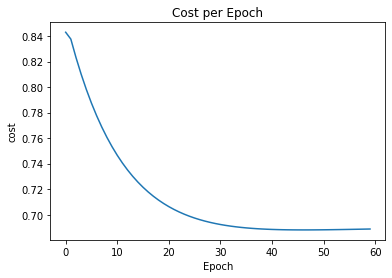

In [18]:
import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.xlabel("Epoch")
plt.ylabel("cost")
plt.title("Cost per Epoch")